# Skin Cancer Detector with HAM10000

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers as opt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import glob
from PIL import Image
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sbn
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

IMG_WIDTH = 64
IMG_HEIGHT = 64
labels=['Basal_Cell_Carcinoma',
        'Benign_Keratosis',
        'Bowens_disease',
        'Dermatofibroma',
        'Melanocytic_Nevi',
        'Melanoma',
        'Vascular_Lesions']


# Let's define some utility functions that will be used in the further analysis.

def print_two_confusion_matrix(cm_list, labels):
    fig, axes = plt.subplots(1,2, figsize=(13,5), subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=1, wspace=1))
    
    key = 0
    for axi, cm in zip(axes, cm_list):
        display = ConfusionMatrixDisplay(cm, display_labels=labels)
        plt.title= 'Naive' if key == 0 else 'Naive Augmented'
        key+=1
        display.plot(ax=axi, xticks_rotation=90)
        plt.ylabel='True Values'
        plt.xlabel='Predicted Values'
    
def print_confusion_matrix(cm, labels):
    display = ConfusionMatrixDisplay(cm, display_labels=labels)
    plt.title= 'Naive with balanced Dataset'
    # sbn.heatmap(cm, square=True, annot=True, cbar=False, fmt='g')
    display.plot(xticks_rotation = 90)
    plt.ylabel = 'True Values'
    plt.xlabel = 'Predicted Values'

def plot_accuracy_epochs(history):
    plt.plot(history['loss'])
    plt.title='Model loss/accuracy'
    plt.ylabel='Loss'
    plt.xlabel='Epoch'
    plt.legend(['Loss'], loc='upper left')

    plt2=plt.twinx()
    color = 'red'
    plt2.plot(history['accuracy'], color=color)
    plt.ylabel='Accuracy'
    plt2.legend(['Accuracy'], loc='upper center')

## Load the data and preprocessing
The dataset contains 10015 images divided in two parts. The 'HAM10000_metadata.csv' contains the ground truth of the dataset. Here we can use this file to retrieve the images from the relative folders and also analyse what category of cancer the image belongs to.

In [37]:
path = '.'
file_name = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(file_name, na_values=['NA','?'])
disease_types = pd.unique(df['dx'])
print(disease_types)
df[:5]

['bkl' 'nv' 'df' 'mel' 'vasc' 'bcc' 'akiec']


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


There are 7 types of skin cancer in the dataset. Let's create a dictionary to better represent those cancers and then replace those with the full name of the skin patology.

In [38]:
images_type = {'bkl': 'Benign_Keratosis', 'nv': 'Melanocytic_Nevi',
                      'df': 'Dermatofibroma', 'mel': 'Melanoma',
                      'vasc': 'Vascular_Lesions', 'bcc': 'Basal_Cell_Carcinoma',
                      'akiec': "Bowens_disease"}
images_type
df.replace(images_type.keys(), images_type.values(), inplace=True)
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear


After having deleted the pieces of data that are not relevant for the analysis, we now check if there are any missing values.

In [39]:
df.isnull().any()

lesion_id       False
image_id        False
dx              False
dx_type         False
age              True
sex             False
localization    False
dtype: bool

From the analysis, it appears that the column of the 'age' has some missing values. To solve this problem we decided to fill those missing values with the median value.

In [40]:
median = df['age'].median()
df['age'] = df['age'].fillna(median)
df.isnull().any()
df

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,Bowens_disease,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,Bowens_disease,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,Bowens_disease,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,Bowens_disease,histo,80.0,male,face


After this brief pre-processing, we can see that there are 10015 images, each with a dimension of 600x450. We are going to reshape those images in a much scaled size 64x64 to improve the performance in terms of speed of processing.

**DISCLAIMER: This piece of code it is not required to be executed. We have already executed it and the resized images are available in the 'Processed_images' folder**

In [215]:
# Specify the path of the directory where the images are contained
# original_images_path = '.'
original_images_path = '/Users/tommasocapecchi/Datasets/HAM10000/Images/'
# Retrieve all the images from the specified directory
images = [img for img in glob.glob(original_images_path+'*.jpg')]
# specify the path where to save the resize images
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/'
# Create a new directory for the processed images, if not already existing
if not 'Processed_images' in os.listdir(save_path):
    os.mkdir(os.path.join(save_path, 'Processed_images')

# Iterate through all the images and resize them. To open an image we are
# going to use the PIL library. Finally, save the new image in the previously created directory.
for img, name in zip(images, df['image_id']):
    data = Image.open(img)
    data = data.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
    data.save(save_path+'Processed_images/'+name+'.jpg')

Now we update the dataframe, inserting a new column named 'image_path' that will specify for each image, the current path in the disk.

In [41]:
# specify the path for the folder 'Processed_images' in order to retrieve the images

# images_dir_path = './Processed_images/'
images_dir_path = '/Users/tommasocapecchi/Datasets/HAM10000/Processed_images/'
images_path = []
for image_name in df['image_id']:
    image_path = os.path.join(images_dir_path, image_name +'.jpg')
    images_path.append(image_path)

# append the path in the disk for each image
df['image_path'] = images_path
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Proce...


And finally we add another column called 'target', that will indeed contain the classification label for each image. As already shown, there are a total of 7 classes of skin cancer (values from 0 to 6)

In [42]:
# Identify the class of the skin cancer and encode them in a range of integers between [0-6].
encoder = preprocessing.LabelEncoder()
labels = encoder.fit_transform(df['dx']).reshape((-1,1))
df['target'] = labels
df[:5]

,lesion_id,image_id,dx,dx_type,age,sex,localization,image_path,target
0,HAM_0000118,ISIC_0027419,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
1,HAM_0000118,ISIC_0025030,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
2,HAM_0002730,ISIC_0026769,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
3,HAM_0002730,ISIC_0025661,Benign_Keratosis,histo,80.0,male,scalp,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1
4,HAM_0001466,ISIC_0031633,Benign_Keratosis,histo,75.0,male,ear,/Users/tommasocapecchi/Datasets/HAM10000/Proce...,1


## Building the model: training and evaluation phase

We are now going to build the actual Convolutional Neural Network to solve the problem of correctly classify the various type of skin cancer. To achieve this goal, first we are going to create a basic implementation to get initial results, then we are going to modify and apply different techniques to improve performances. 

Firstly, we are going to get the actual data from the images. Since each image is a 64x64 image represented in colors, each image will have a shape of (64,64,3) where the final dimension refers to the RGB channel. Each pixel will have a value between 0 and 255.

In [59]:
def build_data():
    X = []
    y = []
    # Iterate through the dataframe selecting the image path (to read the pixels value for each image)
    # and the target value and store those information.
    # into the 
    for path_img, label in zip(df['image_path'].values, df['target'].values):
        img = plt.imread(path_img, format='rgb')
        X.append(img)
        y.append(label)
    y = tf.keras.utils.to_categorical(y, num_classes=7)
    # Reshape the two list as numpy arrays. The X will have the shape (n_images, W, H, RGB)
    X = np.array(X, dtype=('float32')).reshape(-1, IMG_WIDTH, IMG_HEIGHT, 3)

    #It is also a good practice to normalize the values of each pixel into a range between 0 and 1
    # to improve performances in the network.
    X = np.asarray([x/255 for x in X])
    return X, y

Now that the data is completely processed, we can split it into training and validation set using the sklearn library.

In [60]:
X, y = build_data()
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check splitting shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7511, 64, 64, 3)
(2504, 64, 64, 3)
(7511, 7)
(2504, 7)


Before building the model, let's print some of the images to verify that we scaled and shuffled properly the whole collection of the data.

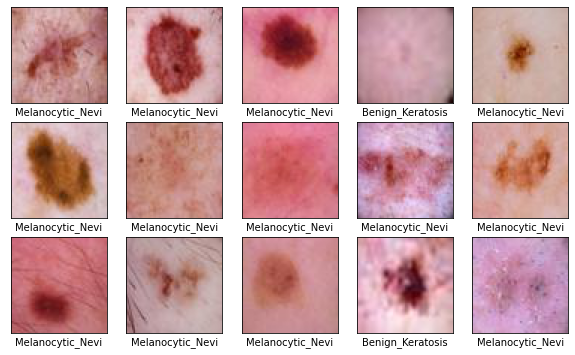

In [28]:
labels=['Basal_Cell_Carcinoma',
        'Benign_Keratosis',
        'Bowens_disease',
        'Dermatofibroma',
        'Melanocytic_Nevi',
        'Melanoma',
        'Vascular_Lesions']

fig, axes= plt.subplots(3,5, figsize=(10,6))
for i, axi in enumerate(axes.flat):
    axi.imshow(X_train[i])
    axi.set(xticks=[], yticks=[],
            xlabel=labels[np.argmax(y_train[i])])
    
plt.show()
plt.close()

Let's now build a naïve CNN to get some initial results and then let's try to adapt the CNN with a model that provides a higher performance.

In [66]:
def simple_CNN():
    model = Sequential()
    model.add(Conv2D(64,
                     kernel_size=(2, 2),
                     strides= 1,
                     padding='same',
                     input_shape=(64, 64, 3),
                     activation='relu'))
    model.add(Conv2D(32,
                     kernel_size=(2, 2),
                     strides= 1,
                     padding='same',
                     activation='relu')),
    model.add(MaxPooling2D(pool_size=(2, 2), strides=1))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(7, activation='softmax'))
    return model

In [67]:
model = simple_CNN()

custom_opt = opt.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 500)               63504500  
_________________________________________________________________
dense_9 (Dense)              (None, 7)                 3507      
Total params: 63,517,063
Trainable params: 63,517,063
Non-trainable params: 0
__________________________________________

In [68]:
# Train the model
history = model.fit(X_train, y_train, batch_size=250, verbose=1, epochs=40)

Epoch 1/40
31/31 [==============================] - 81s 3s/step - loss: 4.6179 - accuracy: 0.6175
Epoch 2/40
31/31 [==============================] - 79s 3s/step - loss: 1.1583 - accuracy: 0.6706
Epoch 3/40
31/31 [==============================] - 78s 3s/step - loss: 1.1421 - accuracy: 0.6706
Epoch 4/40
31/31 [==============================] - 77s 2s/step - loss: 1.1347 - accuracy: 0.6706
Epoch 5/40
31/31 [==============================] - 82s 3s/step - loss: 1.1345 - accuracy: 0.6706
Epoch 6/40
31/31 [==============================] - 80s 3s/step - loss: 1.1645 - accuracy: 0.6707
Epoch 7/40
31/31 [==============================] - 78s 3s/step - loss: 1.1317 - accuracy: 0.6710
Epoch 8/40
31/31 [==============================] - 77s 2s/step - loss: 1.1109 - accuracy: 0.6715
Epoch 9/40
31/31 [==============================] - 80s 3s/step - loss: 1.1034 - accuracy: 0.6722
Epoch 10/40
31/31 [==============================] - 80s 3s/step - loss: 1.1135 - accuracy: 0.6734
Epoch 11/40
31/31 [

It is quite convenient to save the model so that we can retrieve the information later without having to train again the model to find the values for the weights. Let's also visualize the score and the confusion matrix regarding the performance of the model.

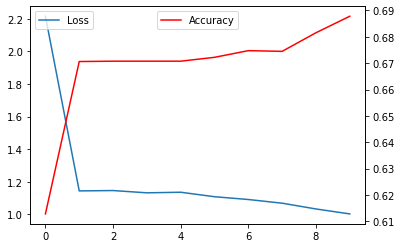

In [77]:
# # Save the training stats
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive'
# # UNCOMMENT TO SAVE THE HISTORY OF THE TRAINING MODEL
# with open(save_path, 'wb') as history_naive_file:
#     pickle.dump(history.history, history_naive_file)

# # UNCOMMENT TO SAVE THE MODEL
# model_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(model_path, 'naive_CNN.h5'))

# # Get the predictions from the test set and compute the accuracy from loaded actual model
# y_pred = model.predict(X_test)
# #now pick the most likely outcome
# y_pred = np.argmax(pred,axis=1)
# y_true = np.argmax(y_test,axis=1) 
# accuracy = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# plot_accuracy_epochs(history.history)

# UNCOMMENT TO LOAD THE HISTORY
history = pickle.load(open('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive', 'rb'))

# UNCOMMENT TO LOAD THE MODEL
model = load_model(os.path.join('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/', 'naive_CNN.h5'))
# Get the predictions from the test set and compute the accuracy from loaded model
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred,axis=1)
y_true = np.argmax(y_test,axis=1) 
accuracy = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
plot_accuracy_epochs(history)

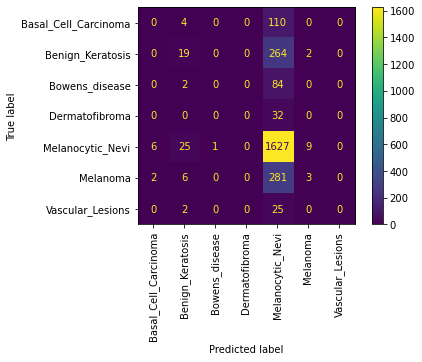

In [81]:
cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm, labels)

From the results, it appears that the CNN recognize each type of cancer as a 'Melanocytic_Nevi'. This problem is related to the fact that the categories in the dataset are highly imbalanced, thus during the training phase the model misclassify every other type of cancers because there are not enough images to build a sufficient general knowlegde.

To confirm this hypothesis we can see the following information:

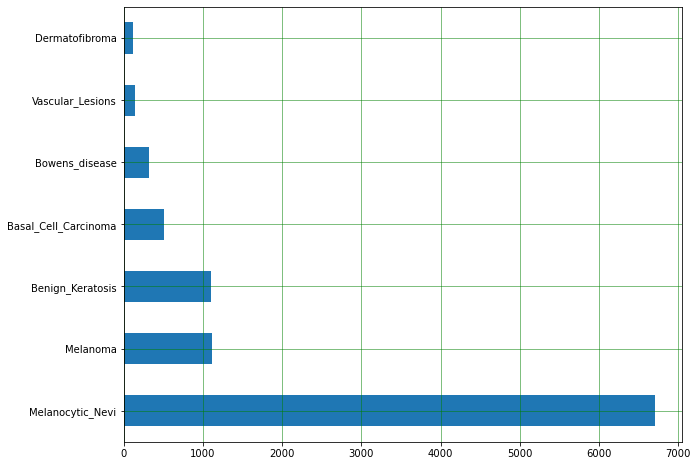

In [43]:
instances_cancer = df['dx'].value_counts()
instances_cancer

instances_cancer.plot(kind='barh', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

## Enhancements: how to improve the system's performance

### Data Augmentation

One way to improve the system could be to generate more artificial data from the images that are already contained in the dataset. We can achieve this goal by using the class ImageDataGenerator of the keras library.

The following function provides the implementation and the technique that we used to generate more data (artificial images) based on the images that we already have in the dataset. The images in the dataset were augmented by selecting all the categories except for the 'Melanocytic_Nevi'. The process stops when all the categories will have reached a good balance in number (approx. 6700 images per category). 


**THE CODE IF EXECUTED WILL RUN FOR A COUPLE OF MINUTES AND WILL PRODUCE A SEPARATE FOLDER OF AUGMENTED IMAGES, STORED IN A GIVE PATH. IT IS NOT NECESSARY TO RUN THIS PIECE OF CODE SINCE WE ALREADY HAVE EXECUTED THE FOLLOWING, AND STORED ALL THE AUGMENTED IMAGES IN THE 'Augmented_images' FOLDER**

In [274]:
# Create a new directory for the augmented images

if not 'Augmented_images' in os.listdir('/Users/tommasocapecchi/Datasets/HAM10000/'):
    os.mkdir('/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images')

def balance_dataset(df, data_gen):
    maximum_images_per_category = np.max(df['dx'].value_counts())
    n_image_to_create = 32
    save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images/'
    for cancer_type in pd.unique(df.dx):
        if cancer_type != 'Melanocytic_Nevi':
            while len(df.loc[df.dx == cancer_type]) < maximum_images_per_category:
                images_per_category = df.loc[df.dx == cancer_type]
                selected_image = images_per_category.sample()
                image_path = selected_image.image_path.values
                try:
                    if 'AUGMENTED' in image_path[0]:
                        continue
                    else:
                        image = plt.imread(image_path[0], format='rgb')
                except Exception as error:
                    print(f'error occured{error}')
                    continue
                image_created_counter = 0
                image = np.asarray(image).reshape((1,IMG_WIDTH, IMG_HEIGHT, 3))
                for batch in data_gen.flow(image, batch_size=1, save_to_dir=save_path,
                                                 save_prefix='AUGMENTED_'+selected_image.image_id.values[0],
                                                 save_format='jpg'):
                    
                    # take all the values in the columns of the already created
                    created_img = selected_image
                    
                    # create the new image id: it's created by the concatenation of the label 'AUGMENTED_'
                    # and the ID of the selected image
                    new_image_id = glob.glob(save_path+'AUGMENTED_'+created_img.image_id.values[0]+'*.jpg')

                    splitted_path = new_image_id[0].split('/')
                    img_id = splitted_path[-1]
                    img_id = img_id[0:-4]

                    created_img.image_id = img_id
                    
                    # Create the new path for the created image: it's the concatenation of the directory that
                    # stores all the images on disk and the new image id (previously created)
                    new_image_path = new_image_id[0]
                    created_img.image_path = new_image_path
                    df = df.append(created_img)
                    break
                print(len(df.loc[df.dx == cancer_type]))
    print(len(df.loc[df.dx == cancer_type]))
    return df

In [ ]:
data_generator = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.3,
                                    fill_mode='nearest',
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    brightness_range=(0.4,0.9))
# The method balance_dataset artifically creates for each category (excluding Melanocytic levi) a series of images
# (generated by choosing randomly an already existing image in the dataset) such that the classes are well
# balanced
# THE EXECUTION OF THIS LINE WILL TAKE A LONG TIME!
# df = balance_dataset(df, data_generator)
# len(df)

**DISCLAIMER: To continue the analysis, it is required to run this piece of code in order to insert the new augmented images in the dataframe. After this process, the original dataset (of 10015 images) will contain 46890 images.
The code will run for a couple of minutes...**

In [18]:
# This piece of code can take few minutes to run but it's necessary to preoceed with the analysis
# Please specify the directory where the augmented images are stored in order to retrieve them and append them in
# the dataframe
augmented_dir = '/Users/tommasocapecchi/Datasets/HAM10000/Augmented_images/'
images = [img for img in glob.glob(augmented_dir+'*.jpg')]
print(len(df))
for path in images:
    image_id_splitted = path.split('/')[-1].split('_')
    last_id_part = image_id_splitted[-1].split('.')[0]
    image_id_original = str(image_id_splitted[1]+'_'+image_id_splitted[2])
    image_id_augmented = image_id_original+str('_'+image_id_splitted[3]+'_'+last_id_part)
    aug_image = df.loc[df.image_id == image_id_original]
    aug_image.image_id = str('AUGMENTED_'+image_id_augmented)
    aug_image.image_path = path
    aug_image.image_path.values
    df = df.append(aug_image)
print(len(df))

10015


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


46890


**Once the dataframe have been created, it is possible to save it in csv format, in order to avoid running again the previous piece of code**

In [45]:
# for convenience the new dataframe is stored in csv file
# df.to_csv('augmented_dataframe.csv')

# Load csv file to create the new augmented dataframe
path = '.'
file_read = os.path.join(path, 'augmented_dataframe.csv')
df = pd.read_csv(file_read, na_values=['NA','?'])

By doing this, we are balancing the data to allow the model not only to recognise the 'Melanocitic_Nevi' but also the other types of images.

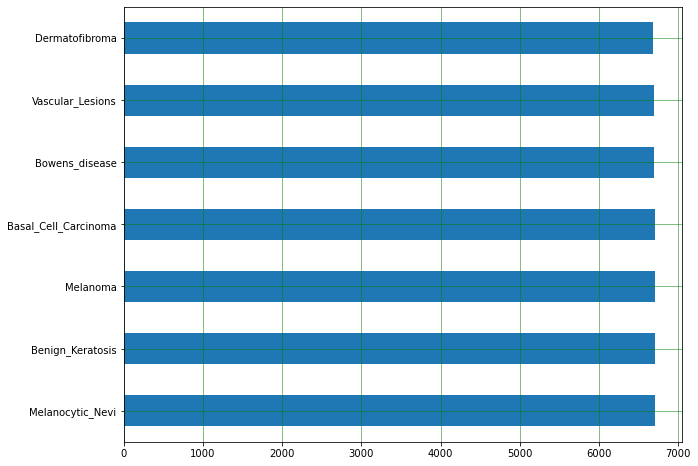

In [46]:
instances_cancer = df['dx'].value_counts()
instances_cancer

instances_cancer.plot(kind='barh', figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

In [47]:
# We are now going to reload our data to execute again the same CNN with the augmented data and a more well
# balanced dataset to see if the performances can improve.

X, y = build_data()
X_train, X_test, y_train,  y_test = train_test_split(X, y, test_size=0.25, random_state=42)
# Check splitting shapes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(35167, 64, 64, 3)
(11723, 64, 64, 3)
(35167, 7)
(11723, 7)


In [48]:
model = simple_CNN()
custom_opt = opt.Adam()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

history = model.fit(X_train, y_train, batch_size=64, verbose=1, epochs=10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 64, 64, 64)        832       
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 64, 64, 32)        8224      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 127008)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 500)               63504500  
_________________________________________________________________
dense_7 (Dense)              (None, 7)                 3507      
Total params: 63,517,063
Trainable params: 63,517,063
Non-trainable params: 0
__________________________________________

KeyboardInterrupt: 

Accuracy: 0.7857214178731902


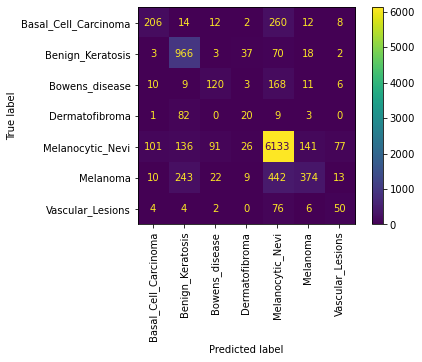

In [90]:
# # UNCOMMENT TO SAVE THE MODEL
# model_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(model_path , 'naive_balanced_dataset_CNN.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/history_naive_balanced_data'
# with open(save_path, 'wb') as hist_naive_balanced_file:
#     pickle.dump(history.history, hist_naive_balanced_file)
    
# # UNCOMMENT TO GET SCORE FROM CURRENT RUN MODEL
# y_pred = model.predict(X_test)
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# score = accuracy_score(y_true, y_pred)
# cm = confusion_matrix(y_true, y_pred)
# print_confusion_matrix(cm, labels)
    
# UNCOMMENT TO LOAD THE MODEL, PLEASE SPECIFY THE PATH OF THE 'naive_balanced_dataset_CNN.h5' FILE
# IN ORDER TO LOAD THE MODEL AND GET THE PREDICTIONS
model = load_model(os.path.join('/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/',
                                'naive_balanced_dataset_CNN.h5'))
# UNCOMMENT TO LOAD THE HISTORY
retrieve_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
history = pickle.load(open(os.path.join(retrieve_path, 'history_naive_balanced_data'), 'rb'))

# GET PREDICTIONS FROM THE STORED RESULTS
# We make our predictions on the original data, not the augmented one. The augmented data is only used
# in the training phase!
X_test, y_test = build_data()
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
cm = confusion_matrix(y_true, y_pred)
print_confusion_matrix(cm, labels)
print(f'Accuracy: {score}')

From the results, it seems that the model radically increased its performace (form .67 accuracy to .78). In the next few sections we will try to implement even more advanced techniques in order to maximize the final results.

## More enhancements: more layers, regularization and early stop.

Now we are going to implement a series of improvement techniques to try to maximize the results from the CNN.
First of all, let's try with a different architecture for the CNN: we are going to both increase the number of filters in the CNN and neurons in the Dense layer. To avoid overfitting or useless waste of time in case that the CNN stops learning after a certain number of epochs, an early stopping criterion in also implemented. 

In [108]:
model = Sequential([
    
    tf.keras.layers.Conv2D(16,
                           kernel_size=(3,3),
                           input_shape=(64,64,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(32,
                           kernel_size=(3,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dense(64, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

monitor = EarlyStopping(monitor='loss', min_delta=1e-5, patience=2, verbose=1, mode='auto')
custom_opt = opt.Adam(beta_2=0.95)
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 64, 64, 16)        448       
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 64, 64, 32)        4640      
_________________________________________________________________
max_pooling2d_39 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 63, 63, 64)        8256      
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 63, 63, 64)        16448     
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 62, 62, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 246016)          

In [109]:
history = model.fit(X_train, y_train, batch_size=512, callbacks=[monitor], verbose=1, epochs=300)

# UNCOMMENT TO SAVE THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model.save(os.path.join(save_path, 'improved_final_CNN.h5'))

# UNCOMMENT TO SAVE THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
with open(save_history_improved, 'wb') as improved_hist_file:
    pickle.dump(history.history, improved_hist_file)

Epoch 1/300
69/69 [==============================] - 690s 10s/step - loss: 2.1058 - accuracy: 0.1717
Epoch 2/300
69/69 [==============================] - 667s 10s/step - loss: 1.8361 - accuracy: 0.2431
Epoch 3/300
69/69 [==============================] - 659s 10s/step - loss: 1.7098 - accuracy: 0.3043
Epoch 4/300
69/69 [==============================] - 662s 10s/step - loss: 1.5698 - accuracy: 0.3555
Epoch 5/300
69/69 [==============================] - 678s 10s/step - loss: 1.4510 - accuracy: 0.3991
Epoch 6/300
69/69 [==============================] - 692s 10s/step - loss: 1.3632 - accuracy: 0.4290
Epoch 7/300
69/69 [==============================] - 686s 10s/step - loss: 1.3053 - accuracy: 0.4496
Epoch 8/300
69/69 [==============================] - 692s 10s/step - loss: 1.2411 - accuracy: 0.4772
Epoch 9/300
69/69 [==============================] - 682s 10s/step - loss: 1.2100 - accuracy: 0.4912
Epoch 10/300
69/69 [==============================] - 656s 10s/step - loss: 1.1995 - accura

Score 0.88


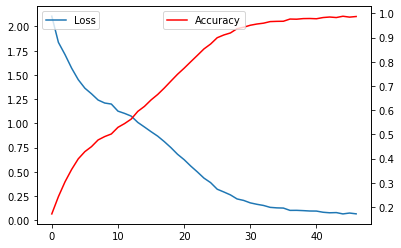

In [91]:
# # UNCOMMENT TO SAVE THE MODEL
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(save_path, 'improved_final_CNN.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
# with open(save_history_improved, 'wb') as improved_hist_file:
#     pickle.dump(history.history, improved_hist_file)

# FROM NOT LOADED
# y_pred_improved = improved_model.predict(X_test)
# y_pred_improved = np.argmax(y_pred_improved, axis=1)
# improved_score = accuracy_score(y_test, y_pred_improved)
# plot_accuracy_epochs(history_improved_load)

# UNCOMMENT TO LOAD THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model = load_model(os.path.join(save_path, 'improved_final_CNN.h5'))

# UNCOMMENT TO LOAD THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history'
history = pickle.load(open(save_history_improved, 'rb'))

# # FROM LOADED MODEL
X_test, y_test = build_data()
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
plot_accuracy_epochs(history)

Score 0.88


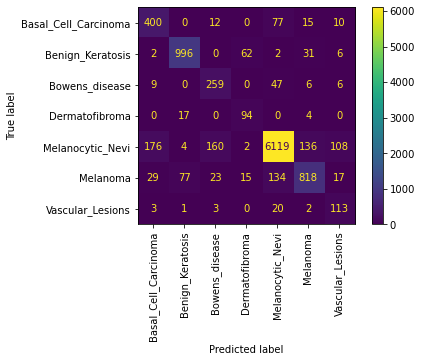

In [92]:
cm = confusion_matrix(y_true, y_pred)
print(f'Score {round(score, 2)}')
print_confusion_matrix(cm, labels)

In [124]:
model = Sequential([
    tf.keras.layers.Conv2D(16,
                           kernel_size=(2,2),
                           input_shape=(64,64,3),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.Conv2D(32,
                           kernel_size=(2,2),
                           strides=1,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Conv2D(64,
                           kernel_size=(2,2),
                           strides=2,
                           padding='same',
                           activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=1),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu', activity_regularizer=regularizers.l2(1e-4)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(7, activation='softmax', kernel_regularizer=regularizers.l2(1e-4))
])

monitor = EarlyStopping(monitor='loss', min_delta=1e-3, patience=2, verbose=1, mode='auto')
custom_opt = opt.SGD()
model.compile(loss='categorical_crossentropy',
              optimizer=custom_opt,
              metrics =['accuracy'])
model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_90 (Conv2D)           (None, 64, 64, 16)        208       
_________________________________________________________________
conv2d_91 (Conv2D)           (None, 64, 64, 32)        2080      
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
flatten_21 (Flatten)         (None, 61504)             0         
_________________________________________________________________
dense_89 (Dense)             (None, 128)             

In [127]:
history = model.fit(X_train, y_train, batch_size=128, callbacks=[monitor], verbose=1, epochs=1000)

Epoch 1/1000
275/275 [==============================] - 210s 762ms/step - loss: 1.9389 - accuracy: 0.1666
Epoch 2/1000
275/275 [==============================] - 209s 760ms/step - loss: 1.9267 - accuracy: 0.1845
Epoch 3/1000
275/275 [==============================] - 207s 754ms/step - loss: 1.9096 - accuracy: 0.2014
Epoch 4/1000
275/275 [==============================] - 208s 756ms/step - loss: 1.8861 - accuracy: 0.2147
Epoch 5/1000
275/275 [==============================] - 207s 753ms/step - loss: 1.8633 - accuracy: 0.2275
Epoch 6/1000
275/275 [==============================] - 206s 750ms/step - loss: 1.8482 - accuracy: 0.2353
Epoch 7/1000
275/275 [==============================] - 210s 764ms/step - loss: 1.8307 - accuracy: 0.2459
Epoch 8/1000
275/275 [==============================] - 210s 764ms/step - loss: 1.8139 - accuracy: 0.2537
Epoch 9/1000
275/275 [==============================] - 203s 740ms/step - loss: 1.7990 - accuracy: 0.2616
Epoch 10/1000
275/275 [=======================

In [128]:
# # UNCOMMENT TO SAVE THE MODEL
# save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
# model.save(os.path.join(save_path, 'improved_final_CNN_best.h5'))

# # UNCOMMENT TO SAVE THE HISTORY
# save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history_best'
# with open(save_history_improved, 'wb') as improved_hist_file:
#     pickle.dump(history.history, improved_hist_file)

Score: 0.9135297054418372


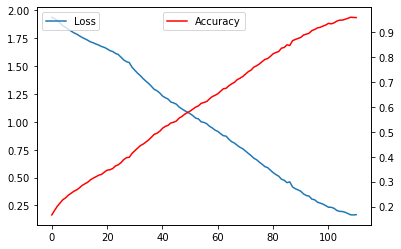

In [93]:
# UNCOMMENT TO LOAD THE MODEL
save_path = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/'
model = load_model(os.path.join(save_path, 'improved_final_CNN_best.h5'))

# UNCOMMENT TO LOAD THE HISTORY
save_history_improved = '/Users/tommasocapecchi/Datasets/HAM10000/Saved_models/improved_final_history_best'
history = pickle.load(open(save_history_improved, 'rb'))

# # FROM LOADED MODEL
X_test, y_test = build_data()
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
score = accuracy_score(y_true, y_pred)
plot_accuracy_epochs(history)
print(f'Score: {score}')

Score: 0.9135297054418372


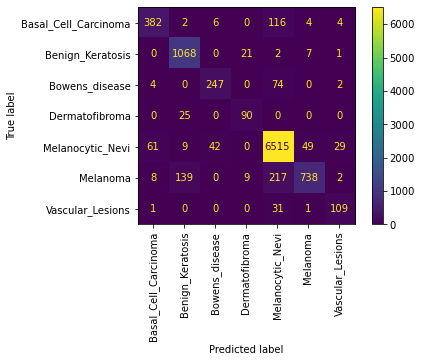

In [94]:
cm = confusion_matrix(y_true, y_pred)
print(f'Score: {score}')
print_confusion_matrix(cm, labels)

As a final observation it is worth plot other metrics with respect to the single category of cancers. This will allows us to understand which type of cancer the model has recognized the most and which none.

In [82]:
from sklearn.metrics import precision_score, recall_score, f1_score

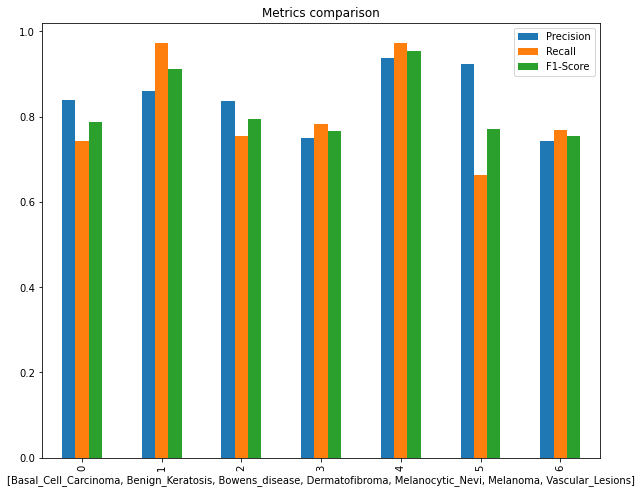

In [99]:
# get correct predictions (diagonal of the confusion matrix)
correct_per_category = [cm[i][i] for i,_ in enumerate(cm)]

# compute the precision: tp/tp+fp

# the denominator for the precision formula is just the sum of the values with respect to the columns
tp_fp = np.sum(cm, axis=0)
precision_scores = np.zeros((len(correct_per_category), 1))
for i, tp in enumerate(correct_per_category):
    precision_scores[i] = tp/(tp_fp[i])
# compute the recall: tp/tp+fn

# the denominator for the precision formula is just the sum of the values with respect to the rows
tp_fn = np.sum(cm, axis=1)
recall_scores = np.zeros((len(correct_per_category), 1))
for i, tp in enumerate(correct_per_category):
    recall_scores[i] = tp/(tp_fn[i])
    
# compute the f1 score: 2* P*R/(P+R)
f1_scores = np.zeros((len(correct_per_category), 1))
i =0
for p, r in zip(precision_scores, recall_scores):
    f1_scores[i] = (2*p*r)/(p+r)
    i+=1
scores = pd.DataFrame(np.c_[precision_scores, recall_scores, f1_scores],
                     columns=['Precision']+['Recall']+['F1-Score'])

# compute accuracy score: TP+TN/(TP+TN+FP+FN)

scores['label'] = labels
scores.plot(kind='bar', figsize=(10,8), xlabel=scores.label, title='Metrics comparison')

# Random Forest Classifier for Skin Lesion Multiclassification Problem

In alternative to the previous model, we now propose to use the Random Decision Forest (or simply Random Forest).
Firstly, we need to import various libraries: pandas will be used for data loading and manipulation,
sklearn will be used for the building of the Machine Learning model as well as for performance metrics

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV

Subsequently, we load the data using pandas' read_csv method. The original dataset was previously augmented in order to balance out the various classes, so that the machine learning models are able to learn each different class appropriately.

In [ ]:
# Load the data and store in a dataframe
path = '.'
file_name = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(file_name, na_values=['NA','?'])

The classifier's goal is to discriminate the data between 7 different classes: Benign Keratosis, Melanocytic Nevi, Dermatofibroma, Melanoma, Vascular Lesions, Basal Cell Carcinoma, and Bowens disease.
Below is a snippet of the csv file, from which we will extract the features for the classification task

In [ ]:
df.head()

We check that there are no missing values:

In [ ]:
df.isnull().any()

As it appears, the 'age' column has some missing values, so we fill in these gaps by using the median age. 

In [ ]:
median = df['age'].median()
df['age'] = df['age'].fillna(median)

Before we can parse the data into our Random Forest, we must convert all string type values into numeric ones, as the Random Forest classifier implemented in Scikit-learn only takes these values as input. 
the datapoints which must be converted into numeric values are in the 'sex', 'localization' and 'dx_type' columns.
The values for gender should supposedly be binary, however not all datapoints have this feature, thus some have been filled in as 'unknown' gender. 

In [ ]:
sex_dict = {'male': 0, 'female': 1, 'unknown': 2}
df['sex_2'] = df['sex'].apply(sex_dict.get).astype(float)

We continue to convert the columns 'localization' and 'dx_type' using a dictionary to pair the string value to a numeric one:

In [ ]:
dx_type_dict = {'histo': 0, 'consensus': 1, 'follow_up': 2, 'confocal': 3}
df['dx_type2'] = df['dx_type'].apply(dx_type_dict.get).astype(float)

localization_dict = {'scalp': 0, 'ear': 1, 'face': 2, 'back': 3, 'trunk': 4, 'chest': 5, 'upper extremity': 6,
'abdomen': 7, 'unknown': 8, 'lower extremity': 9, 'genital': 10, 'neck': 11, 'hand': 12, 'foot': 13, 'acral': 14}
df['loc_2'] = df['localization'].apply(localization_dict.get).astype(float)

Now we create a subset of the dataframe as X and y, for the feature map and the targets respectively:

In [ ]:
X = df[['age', 'sex_2', 'loc_2', 'dx_type2']].values
y = df['target'].values

By using the .values method to our dataframe, we are able to convert the dataframe into a numpy array.

In [ ]:
print(X.shape)
print(y.shape)

Now we split the dataset into a training set and a testing set. We are facilitated by Scikit-learn's train_test_split method, which takes our X and y variables as input and returns a 75-25% split on our dataset. The random_state parameter is used so that each time the code is run the same random split is executed. The shuffle parameter is set to True so that our datapoints are shuffled before being allocated into either the training or test set. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7, shuffle=True)

Before we can build our Random Forest, it is important to find out the optimal number of decision trees for our random forest.
This way we are able to optimize our model, without unnecessarily adding computational complexity. 

In [ ]:
param_grid = {'n_estimators': [10, 25, 50, 75, 100]}
gs = GridSearchCV(rfc, param_grid, cv = 5)
gs.fit(X_train, y_train)
print("best params: ", gs.best_params_)

Building the Random forest: 

In [ ]:
rfc = RandomForestClassifier(criterion= 'entropy', random_state=24, n_estimators=75)
rfc.fit(X_train, y_train)

Evaluating the model with our training set:
    

In [ ]:
y_pred = rfc.predict(X_test)

Calculating the performance metrics:

In [ ]:
print("F1-Score: ", f1_score(y_test, y_pred, average='micro'))
print("Accuracy: ", accuracy_score(y_test, y_pred))
print("Error Rate: ", 1 -(accuracy_score(y_test, y_pred)))
print("Precision: " , precision_score(y_test, y_pred, average='micro'))
print("Recall: ", recall_score(y_test, y_pred, average='micro'))
print()
print("The Classification Report: ")
print(classification_report(y_test, y_pred))

Visualizing the Confusion Matrix:

In [ ]:
plot_confusion_matrix(rfc, X_test, y_test)